In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
import pandas as pd
import pybedtools as pbed
import os
import math
import statistics
import concurrent.futures

os.makedirs("/mnt/iusers01/jw01/mdefscs4/scratch/temp_pybedtools/", exist_ok = True)
pbed.helpers.set_tempdir("/mnt/iusers01/jw01/mdefscs4/scratch/temp_pybedtools/")
bed_genome_file = "/mnt/iusers01/jw01/mdefscs4/hg38.genome"

In [3]:
import sys
sys.path.append("..")
from configuration import Config

In [4]:
Configuration = Config()

In [5]:
tss_sites = "/mnt/iusers01/jw01/mdefscs4/psa_functional_genomics/NEW_references/genes/gencode.v29.TSS_sites_protein_coding_sorted.bed"

In [6]:
tss_bed = pbed.BedTool(tss_sites)
tss_bed = tss_bed.slop(b=2000,g=bed_genome_file)

In [7]:
import subprocess
def wccount(filename):
    out = subprocess.Popen(['wc', '-l', filename],
                         stdout=subprocess.PIPE,
                         stderr=subprocess.STDOUT
                         ).communicate()[0]
    return int(out.partition(b' ')[0])

def samtools_count(filename):
    out = subprocess.Popen(['samtools','view','-c', filename],
                         stdout=subprocess.PIPE,
                         stderr=subprocess.STDOUT
                         ).communicate()[0]
    return int(out)

def calculate_FRiP(tss_bed, genrich, macs, bam_file):
    bam_bed = pbed.BedTool(bam_file)
    reads_in_tss = bam_bed.intersect(tss_bed,bed=True,u=True).fn
    reads_in_macs = bam_bed.intersect(macs,bed=True,u=True).fn
    reads_in_genrich = bam_bed.intersect(genrich,bed=True,u=True).fn
    reads_in_tss = wccount(reads_in_tss)
    reads_in_macs = wccount(reads_in_macs)
    reads_in_genrich = wccount(reads_in_genrich)
    total_reads = samtools_count(bam_bed.fn)
    return reads_in_tss/total_reads, reads_in_macs/total_reads, reads_in_genrich/total_reads

def call_frip(sample):
    return calculate_FRiP(tss_bed, 
                          pbed.BedTool(os.path.join(Configuration.genrich_dir,sample,sample + "_genrich.bed")), 
                          pbed.BedTool(os.path.join(Configuration.macs2_dir,sample,sample + "_peaks.narrowPeak")), 
                          os.path.join(Configuration.cleaned_alignments_dir,sample,sample + "_align_dedup.bam"))

In [11]:
import glob
files = [os.path.basename(x) for x in glob.glob('/mnt/jw01-aruk-home01/projects/psa_functional_genomics/master_ATAC_ChIP_analyzer/clean_alignments/*ATAC')]

In [12]:
results = []
with concurrent.futures.ProcessPoolExecutor() as executor:
        for i, res in zip(files, executor.map(call_frip,files)):
            print(i, f"reads in tss: {res[0]:.2f}, reads in macs peaks {res[1]:.2f}, reads in genrich peaks {res[2]:.2f}")
            results.append(res)

In [8]:
samtools_count('/mnt/jw01-aruk-home01/projects/psa_functional_genomics/master_ATAC_ChIP_analyzer/clean_alignments/PsA5036CD8_ATAC/PsA5036CD8_ATAC_align_dedup.bam')

212179372

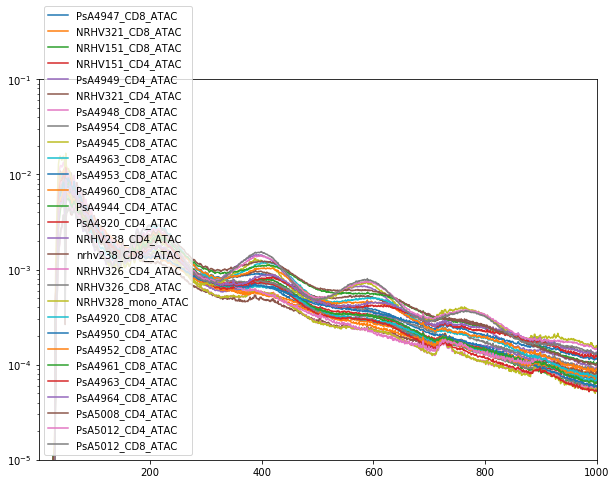

In [ ]:
plt.figure(figsize=(10,7))
for sample in files:
    data = pd.read_csv(os.path.join(Configuration.other_qc_dir,sample,sample + "_fragment_length_count.txt"), sep = " ",header=None)
    plt.plot(data[1],data[0]/sum(data[0]), label = sample)
    plt.xlim(1,1000)
    plt.ylim(1e-5,1e-1)
    plt.yscale("log")
    plt.legend()